# CFL on Galaxy Dataset 
This notebook runs CFL on the galaxy dataset and visualizes the results. X data is comprised of two input images (a gas map and dark matter map). Y data is comprised of six parameters describing the simulated telescope image that results from these input maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import cfl
from cfl.cfl_wrapper import make_CFL
from cfl.save.experiment_saver import ExperimentSaver
from cfl.dataset import Dataset

# Load and Inspect Dataset

In [2]:
# load data
cfl_path = '/Users/imanwahle/Desktop/cfl'
Xraw = np.load(os.path.join(cfl_path, 'data/galaxies/X.npy'))
Yraw = np.load(os.path.join(cfl_path, 'data/galaxies/Y.npy'))
print('Xraw shape: ', Xraw.shape)
print('Yraw shape: ', Yraw.shape)

Xraw shape:  (8643, 5202)
Yraw shape:  (8643, 6)


min,max raw img 0: -111209.03876876831,0.0
min,max raw img 1: 0.0,73430.0


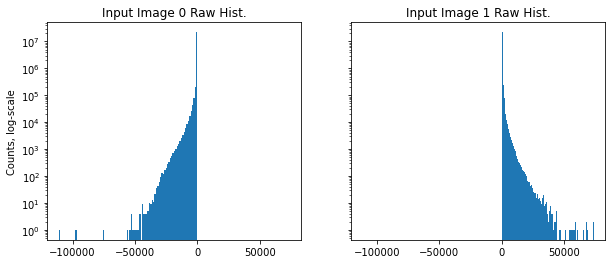

In [3]:
print('min, max raw img 0: {}, {}'.format(np.min(Xraw[:,:2601]),np.max(Xraw[:,:2601])))
print('min, max raw img 1: {}, {}'.format(np.min(Xraw[:,2601:]),np.max(Xraw[:,2601:])))
fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
ax[0].hist(np.ravel(Xraw[:,:2601]),100)
ax[0].set_title('Input Image 0 Raw Hist.')
ax[0].set_yscale('log')
ax[0].set_ylabel('Counts, log-scale')
ax[1].hist(np.ravel(Xraw[:,2601:]),100)
ax[1].set_title('Input Image 1 Raw Hist.')
ax[0].set_yscale('log')
plt.show()


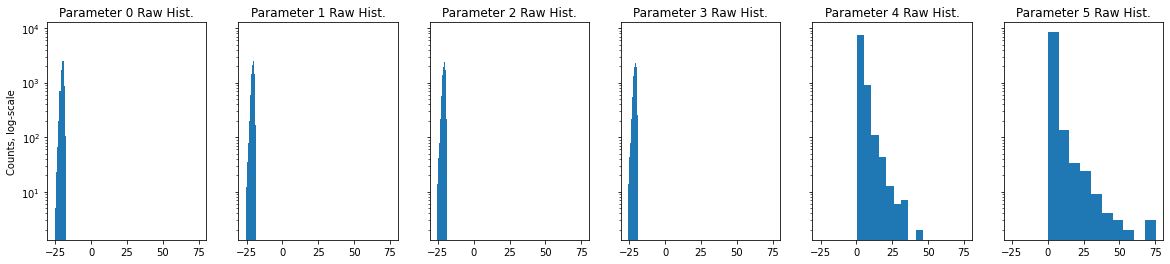

In [4]:
fig,ax = plt.subplots(1,6,figsize=(20,4), sharex=True, sharey=True)
for i in range(6):
    ax[i].hist(Yraw[:,i],10)
    ax[i].set_title('Parameter {} Raw Hist.'.format(i))
    ax[i].set_yscale('log') 
ax[0].set_ylabel('Counts, log-scale')
plt.show()


# Rescale Data

In [8]:
# Xraw data should be arcsinhed and scaled 0-1
X = np.arcsinh(Xraw)
X = X - X.min(axis=0)
X = X / X.max(axis=0)

# Yraw should be z-scored
Y = Yraw - Yraw.mean(axis=0)
Y = Y / Y.std(axis=0)

min, max img 0: 0.0, 1.0
min, max img 1: 0.0, 1.0


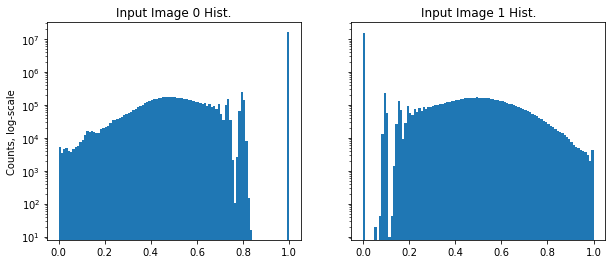

In [9]:
print('min, max img 0: {}, {}'.format(np.min(X[:,:2601]),np.max(X[:,:2601])))
print('min, max img 1: {}, {}'.format(np.min(X[:,2601:]),np.max(X[:,2601:])))

fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
ax[0].hist(np.ravel(X[:,:2601]),100)
ax[0].set_title('Input Image 0 Hist.')
ax[0].set_yscale('log')
ax[0].set_ylabel('Counts, log-scale')
ax[1].hist(np.ravel(X[:,2601:]),100)
ax[1].set_title('Input Image 1 Hist.')
ax[1].set_yscale('log')
plt.show()


param 0 min: -5.084923879152289, max: 2.6816166006810707
param 1 min: -4.835309458724446, max: 2.3333343493773886
param 2 min: -4.71837822619073, max: 2.1926626890132592
param 3 min: -4.648840457422656, max: 2.1117426606850382
param 4 min: -1.1953675147308491, max: 17.887880401785317
param 5 min: -0.36990860551779914, max: 22.570458850880186


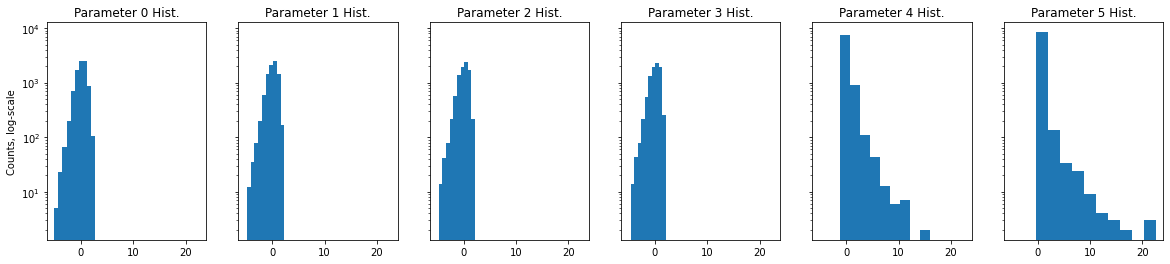

In [10]:
fig,ax = plt.subplots(1,6,figsize=(20,4), sharex=True, sharey=True)
for i in range(6):
    ax[i].hist(Y[:,i],10)
    ax[i].set_title('Parameter {} Hist.'.format(i))
    ax[i].set_yscale('log')
    print('param {} min: {}, max: {}'.format(i, np.min(Y[:,i]),np.max(Y[:,i])))
ax[0].set_ylabel('Counts, log-scale')
plt.show()


# Run CFL

In [11]:
# start experiment
experiment_saver = ExperimentSaver('results/galaxies')

# register dataset
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver)

All results from this run will be saved to results/galaxies/experiment0004


In [12]:
# specify CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 64,
               'optimizer'   : 'adam',
               'n_epochs'    : 150,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [1000, 100, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'linear'],
               'dropouts'    : [0.1, 0.1, 0], 
               'show_plot'   : True,
               'weights_path': 'results/galaxies/experiment0000/dataset0/checkpoints/best_weights' }

    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 4 }

In [13]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpMod', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) 

loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod
Loading parameters from  results/galaxies/experiment0000/dataset0/checkpoints/best_weights


In [14]:
# train
train_results = cfl_object.train(dataset0, standardize=False)

No need to train, specified weights loaded already.
100%|██████████| 8643/8643 [00:11<00:00, 757.02it/s]


In [15]:
# predict
dataset1 = Dataset(X[:,:], Y[:,:], dataset_label='dataset1', experiment_saver=experiment_saver) 
xlbls,ylbls = cfl_object.predict(dataset1)


100%|██████████| 8643/8643 [00:09<00:00, 885.32it/s]


# Visualize Examples from X Macrovar Classes

In [16]:
from galaxy_util import reshape_input, calculate_arp

Examples of Input Image 0 by Class


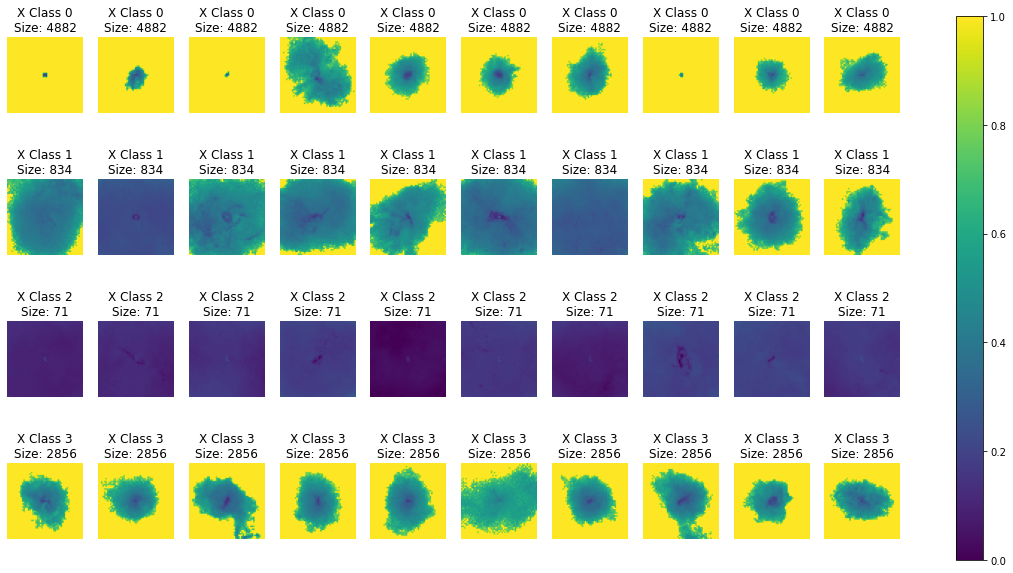

In [17]:
print('Examples of Input Image 0 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
figmin = np.min(dataset1.X[:,:2601])
figmax = np.max(dataset1.X[:,:2601])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        im = ax[i,j].imshow(reshape_input(dataset1.X[class_samples[j]],0), vmin=figmin, vmax=figmax)
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
        ax[i,j].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))
fig.colorbar(im, ax=ax)
plt.show()


Examples of Input Image 1 by Class


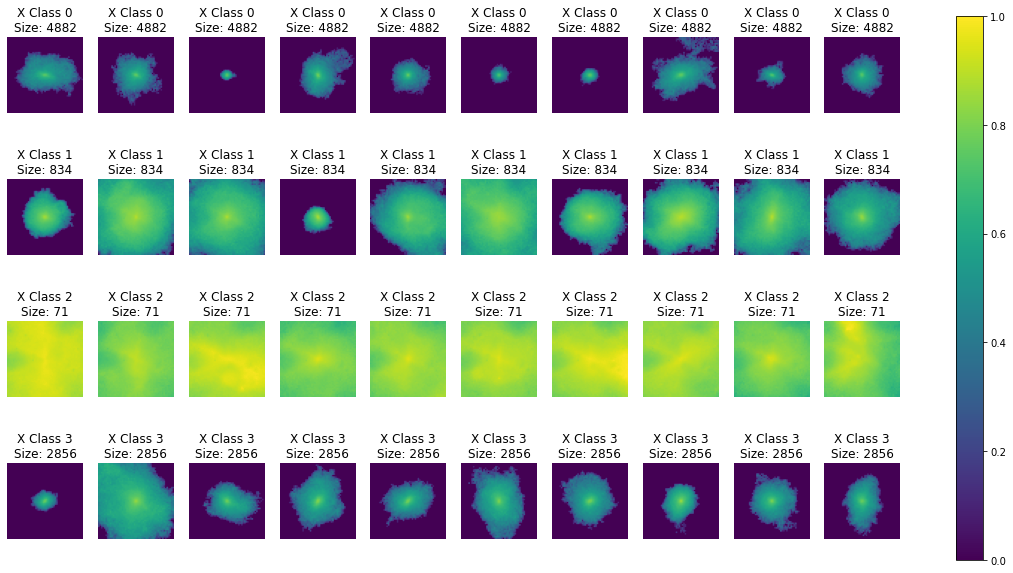

In [18]:
print('Examples of Input Image 1 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
figmin = np.min(dataset1.X[:,2601:])
figmax = np.max(dataset1.X[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        ax[i,j].imshow(reshape_input(dataset1.X[class_samples[j]],1),vmin=figmin, vmax=figmax)
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
        ax[i,j].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))
fig.colorbar(im, ax=ax)
plt.show()


# Visualize Average of Each X Macrovar Class

Average of Input Image 0 by X Macrovariable Class


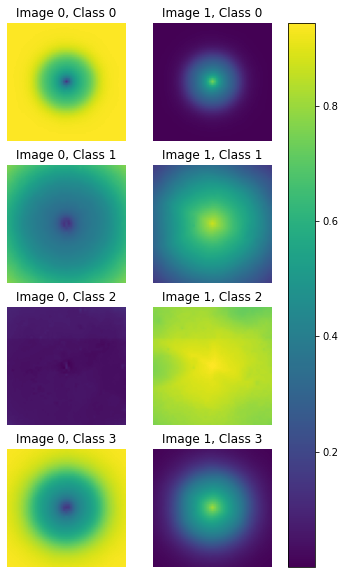

In [30]:
print('Average of Input Image 0 by X Macrovariable Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 2, figsize=(6,10))
class_means = np.zeros((cluster_params['n_Xclusters'], dataset1.X.shape[1]))
for i in range(cluster_params['n_Xclusters']):
    class_means[i,:] = np.mean(dataset1.X[xlbls==i,:],axis=0)
vmin = np.min(class_means[:,:2601]), np.min(class_means[:,2601:])
vmax = np.max(class_means[:,:2601]), np.max(class_means[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    for j in range(2):
        im = ax[i,j].imshow(reshape_input(class_means[i], j), vmin=vmin[j], vmax=vmax[j])
        ax[i,j].set_title('Image {}, Class {}'.format(j,i))
        ax[i,j].axis('off')

fig.colorbar(im, ax=ax)
plt.show()


# Plot Average Radial Profile (ARP)

Example input image1 and corresponding ARP:


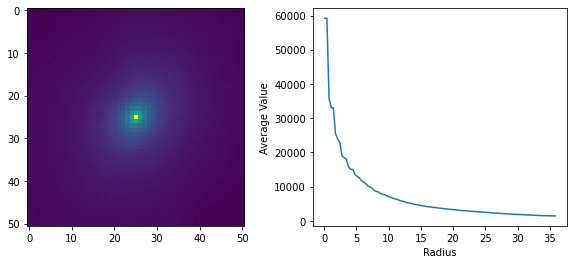

In [31]:
print('Example input image1 and corresponding ARP:')
fig,ax = plt.subplots(1,2,figsize=(10,4))
tmp_image = Xraw[0,2601:].reshape((51,51))
ax[0].imshow(tmp_image)

r, mean = calculate_arp(tmp_image)
ax[1].plot(r, mean)
ax[1].set_xlabel('Radius')
ax[1].set_ylabel('Average Value')
plt.show()

Examples of Input RAW image1 ARP by Class, log-log scale


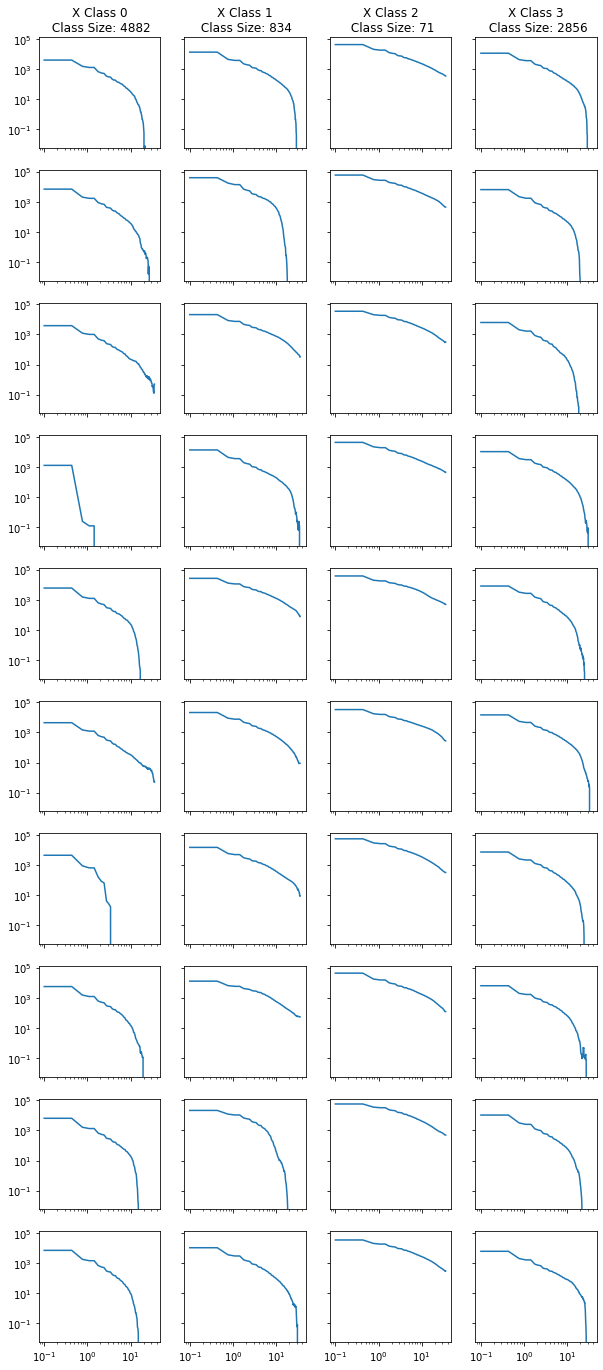

In [38]:
print('Examples of Input RAW image1 ARP by Class, log-log scale')
fig,ax = plt.subplots(10, cluster_params['n_Xclusters'], figsize=(10,24), sharex=True, sharey=True)
figmin = np.min(Xraw[:,2601:])
figmax = np.max(Xraw[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        r, mean = calculate_arp(reshape_input(Xraw[class_samples[j]], im_no=1))
        im = ax[j,i].loglog(r, mean)
        if j==0:
            ax[j,i].set_title('X Class {}\n Class Size: {}'.format(i, np.sum(xlbls==i)))
        # ax[j,i].set_yticklabels([])
        # ax[j,i].set_xticklabels([])
plt.show()


Average of Input RAW image1 ARPs by Class. Blue = average.


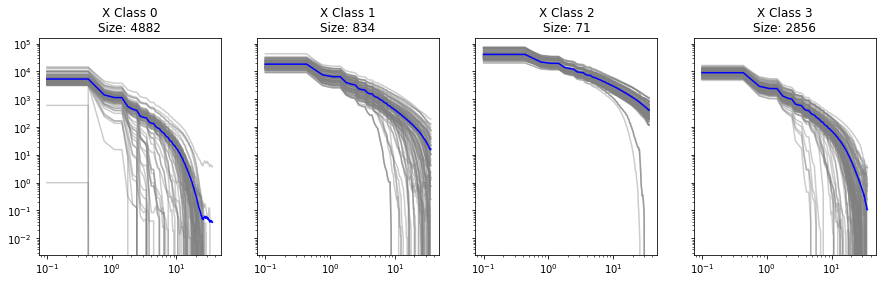

In [37]:
print('Average of Input RAW image1 ARPs by Class. Blue = average.')
fig,ax = plt.subplots(1, cluster_params['n_Xclusters'], figsize=(15,4), sharex=True, sharey=True)
figmin = np.min(Xraw[:,2601:])
figmax = np.max(Xraw[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 100)
    means = np.zeros((100,300))
    for j in range(100):
        r, mean = calculate_arp(reshape_input(Xraw[class_samples[j]], im_no=1))
        means[j] = mean
        im = ax[i].loglog(r, mean, c='gray',alpha=0.4)
    ax[i].plot(r, means.mean(axis=0), c='blue')
    ax[i].set_title('class {}'.format(i))
    # ax[i].axis('off')
    ax[i].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))

plt.show()


# PCA Visualizations

In [39]:
from sklearn.decomposition import PCA

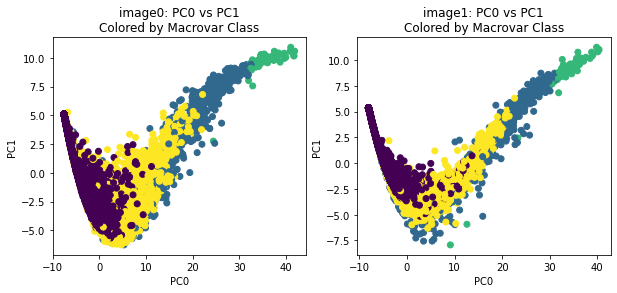

In [43]:
pca0 = PCA(n_components=10)
Xred_img0 = pca0.fit_transform(dataset1.X[:,:2601])

pca1 = PCA(n_components=10)
Xred_img1 = pca1.fit_transform(dataset1.X[:,2601:])

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(Xred_img0[:,0],Xred_img0[:,1], c=xlbls)
ax[0].set_title('image0: PC0 vs PC1\nColored by Macrovar Class')
ax[0].set_xlabel('PC0')
ax[0].set_ylabel('PC1')
ax[1].scatter(Xred_img1[:,0],Xred_img1[:,1], c=xlbls)
ax[1].set_title('image1: PC0 vs PC1\nColored by Macrovar Class')
ax[1].set_xlabel('PC0')
ax[1].set_ylabel('PC1')
plt.show()

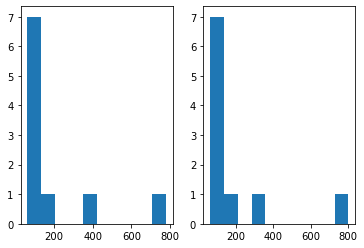

In [45]:
fig,ax = plt.subplots(1,2)
ax[0].hist(pca0.singular_values_)
ax[1].hist(pca1.singular_values_)
plt.show()

PCA principal axes, image 0:


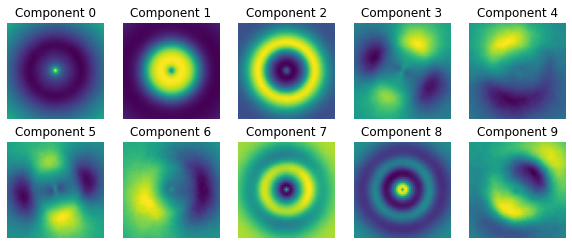


PCA principal axes, image 1:


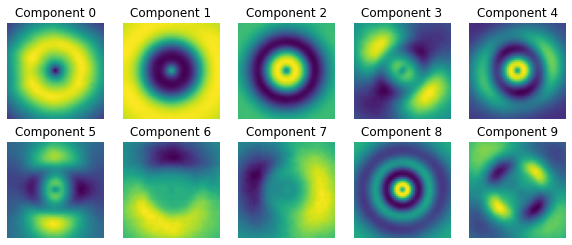

In [52]:

for i in range(2):
    print ('PCA principal axes, image {}:'.format(i))
    eigenvecs = pcas[i].components_
    fig,axs=plt.subplots(2,5,figsize=(10,4))
    for comp,ax in zip(range(eigenvecs.shape[0]),axs.ravel()):
        ax.imshow(eigenvecs[comp,:].reshape((51,51)))
        ax.set_title('Component {}'.format(comp))
        ax.axis('off')
    plt.show()
    print()


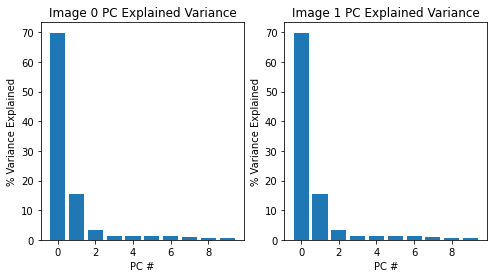

In [53]:
pcas = [pca0, pca1]
fig,ax = plt.subplots(1,2,figsize=(8,4))
for i in range(2):
    ax[i].bar(range(len(pca0.explained_variance_)),pca0.explained_variance_)
    ax[i].set_xlabel('PC #')
    ax[i].set_ylabel('% Variance Explained')
    ax[i].set_title('Image {} PC Explained Variance'.format(i))
plt.show()

Examples of image 0 along as PC0 and PC1 vary independently.


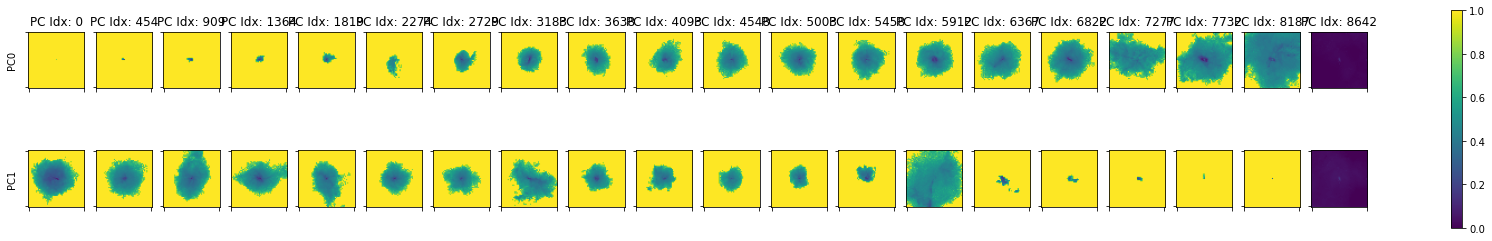

Examples of image 1 along as PC0 and PC1 vary independently.


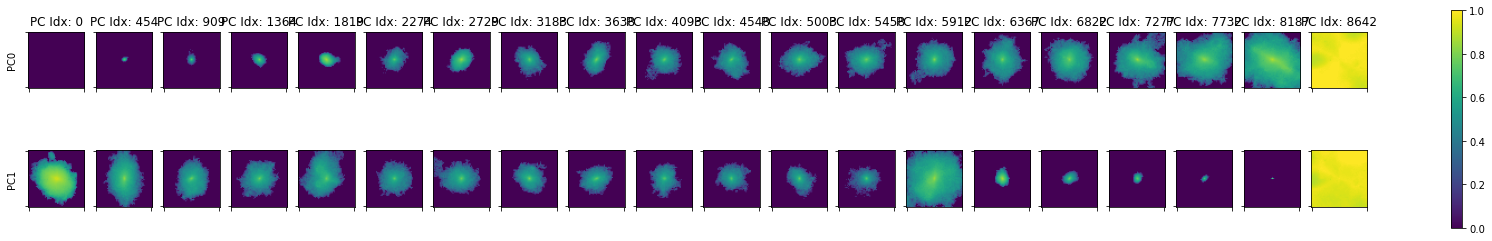

In [51]:
# Plot examples of image0 along each PC
Xreds = [Xred_img0, Xred_img1]
for xri in range(2):
    n_samples = 20
    sample_idx = np.linspace(0,Xreds[xri].shape[0]-1,n_samples).astype(int)

    sorted_idx0 = np.argsort(Xreds[xri][:,0])
    samples_to_plot0 = sorted_idx0[sample_idx]

    sorted_idx1 = np.argsort(Xreds[xri][:,1])
    samples_to_plot1 = sorted_idx1[sample_idx]

    print('Examples of image {} along as PC0 and PC1 vary independently.'.format(xri))
    fig,ax = plt.subplots(2,n_samples,figsize=(30,4))
    figmin = np.min(dataset1.X[:,:2601])
    figmax = np.max(dataset1.X[:,:2601])
    for i in range(n_samples):
        im = ax[0,i].imshow(reshape_input(dataset1.X[samples_to_plot0[i]], im_no=xri), vmin=figmin, vmax=figmax)
        ax[1,i].imshow(reshape_input(dataset1.X[samples_to_plot1[i]], im_no=xri), vmin=figmin, vmax=figmax)
        # ax[0,1].set_title('')
        for j in range(2):
            ax[j,i].set_yticklabels([])
            ax[j,i].set_xticklabels([])
        ax[0,i].set_title('PC Idx: {}'.format(sample_idx[i]))

    ax[0,0].set_ylabel('PC0')
    ax[1,0].set_ylabel('PC1')

    fig.colorbar(im, ax=ax)
    plt.show()

# Macrovariable Conditional Probability

We now have macrovariables on the X side and 6 microvariable parameters on the Y side. We want to know what the distribution of each Y parameter looks like given each X macrovariable class.

Histograms of each Y parameter given each X macrovariable class. Histograms are normalized so the sum equals to 1. Red = mean of sample.


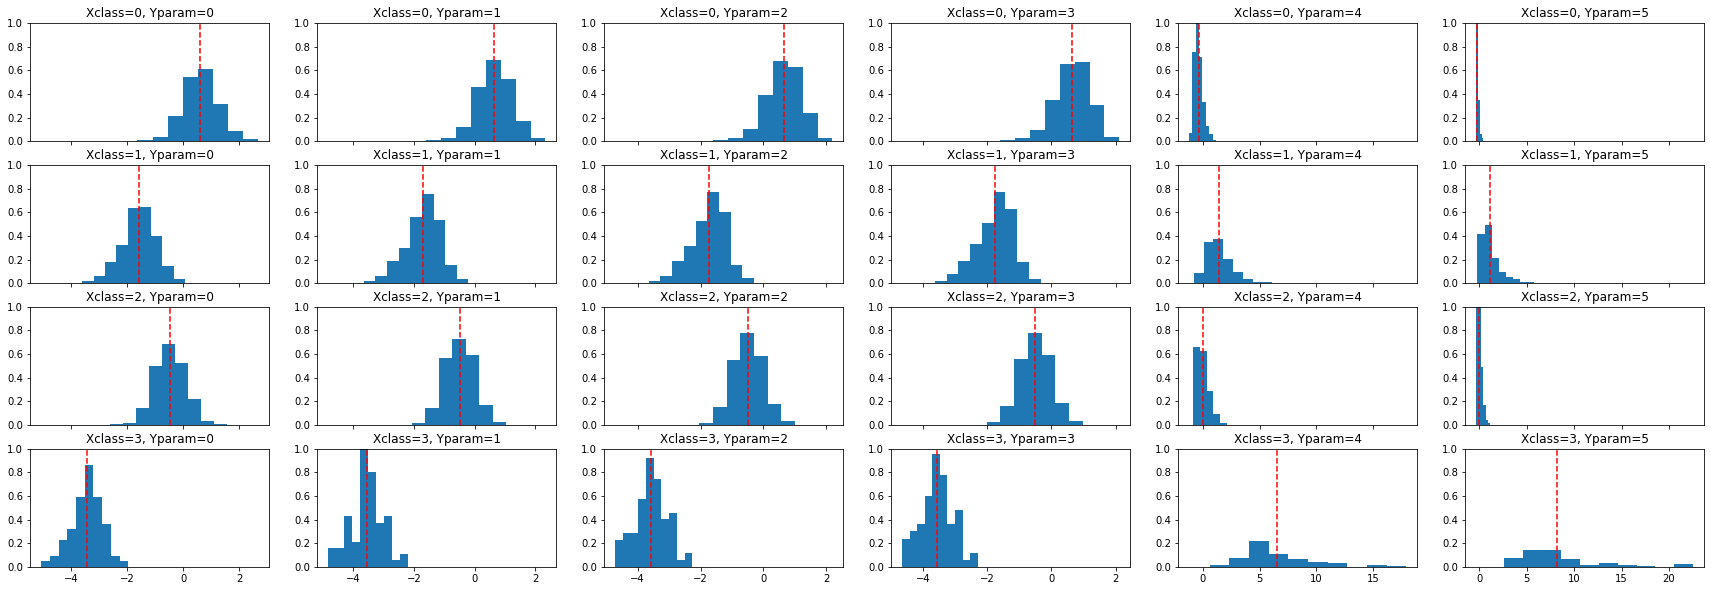

In [23]:
print('Histograms of each Y parameter given each X macrovariable class. Histograms are normalized so the sum equals to 1. Red = mean of sample.')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], dataset1.Y.shape[1], figsize=(30,10),sharex='col')

for xclassidx in range(cluster_params['n_Xclusters']):
    corresponding_yparams = dataset1.Y[xlbls==xclassidx,:]
    for yparamidx in range(dataset1.Y.shape[1]):
        ax[xclassidx,yparamidx].hist(corresponding_yparams[:,yparamidx],density=True)
        ax[xclassidx,yparamidx].set_title('Xclass={}, Yparam={}'.format(xclassidx,yparamidx))
        ax[xclassidx,yparamidx].set_ylim((0,1))
        ax[xclassidx,yparamidx].axvline(corresponding_yparams[:,yparamidx].mean(),c='red', linestyle='--')
